# Chapter 06 - Statistical Machine Learning

In [1]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product

## K-Nearest Neighbors

The idea behind KNN is pretty simple:

1. Find K records that have similar features (i.e., similar predictor values).
2. For classification, find out what the majority class is among those similar records and assign that class to the new record.
3. For prediction (also called KNN regression), find the average among those similar records, and predict that average for the new record.

### A Small Example: Predicting Loan Default

In [2]:
LOAN200_CSV = '../data/loan200.csv'
LOAN3000_CSV = '../data/loan3000.csv'
LOAN_DATA_CSV = '../data/loan_data.csv.gz'

In [3]:
loan200 = pd.read_csv(LOAN200_CSV)
loan200.head()

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [4]:
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

In [5]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


The probability of belonging to a class is given by the proportion of neighbors from that class among K.  In the preceding example, this probability of default would have been estimated at 9/20, or 0.45.

### Distance Metrics

In measuring distance between two vectors, we must watch out for difference in scale between variables. Features that have a higher order of magnitude will likely dominate and have almost all influence over the algorithm. To mitigate this problem, we can use the standardized version of the features, such as the Z-Score.

### Choosing K

Generally speaking, if K is too low (close to 1), we may be overfitting; including the noise in the data. Higher values of K provide smoothing that reduces the risk of overfitting in the training data. On the other hand, if K is too high, we may oversmooth the data and miss out on KNN's ability to capture the local structure in the data, one of its main advantages.

The K that best balances between overfitting and oversmoothing is typically determined by accuracy metrics and, in particular, accuracy with holdout or validation data. There is no general rule about the best K—it depends greatly on the nature of the data. For highly structured data with little noise, smaller values of K work best. Borrowing a term from the signal processing community, this type of data is sometimes referred to as having a high signal-to-noise ratio (SNR). Examples of data with a typically high SNR are data sets for handwriting and speech recognition. For noisy data with less structure (data with a low SNR), such as the loan data, larger values of K are appropriate. Typically, values of K fall in the range 1 to 20. Often, an odd number is chosen to avoid ties.

### KNN as a Feature Engine

s. In practical model fitting, however, KNN can be used to add “local
knowledge” in a staged process with other classification techniques:

1. KNN is run on the data, and for each record, a classification (or quasi-probability of a class) is derived.
2. That result is added as a new feature to the record, and another classification method is then run on the data. The original predictor variables are thus used twice.

At first you might wonder whether this process, since it uses some predictors twice, causes a problem with multicollinearity (see “Multicollinearity” on page 172). This is not an issue, since the information being incorporated into the second-stage model is highly local, derived only from a few nearby records, and is therefore additional information and not redundant.

You can think of this staged use of KNN as a form of ensemble learning, in which multiple predictive modeling methods are used in conjunction with one another. It can also be considered as a form of feature engineering in which the aim is to derive features (predictor variables) that have predictive power. Often this involves some manual review of the data; KNN gives a fairly automatic way to do this.

For example, consider the King County housing data. In pricing a home for sale, a realtor will base the price on similar homes recently sold, known as “comps.” In essence, realtors are doing a manual version of KNN: by looking at the sale prices of similar homes, they can estimate what a home will sell for. We can create a new fea‐ ture for a statistical model to mimic the real estate professional by applying KNN to recent sales. The predicted value is the sales price, and the existing predictor variables could include location, total square feet, type of structure, lot size, and number of bedrooms and bathrooms. The new predictor variable (feature) that we add via KNN is the KNN predictor for each record (analogous to the realtors’ comps). Since we are predicting a numerical value, the average of the K-Nearest Neighbors is used instead of a majority vote (known as KNN regression).

Similarly, for the loan data, we can create features that represent different aspects of the loan process. For example, the following code would build a feature that represents a borrower’s creditworthiness:

In [6]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc',
 'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

loan_data['borrower_score'] = knn.predict_proba(X)[:, 1]
loan_data['borrower_score'].describe()

count    45342.000000
mean         0.498902
std          0.128736
min          0.050000
25%          0.400000
50%          0.500000
75%          0.600000
max          1.000000
Name: borrower_score, dtype: float64

The result is a feature that predicts the likelihood a borrower will default based on his credit history.

## Tree Models

A tree model is a set of “if-then-else” rules that are easy to understand and to implement. In contrast to linear and logistic regression, trees have the ability to discover hidden patterns corresponding to complex interactions in the data. However, unlike KNN or naive Bayes, simple tree models can be expressed in terms of predictor relationships that are easily interpretable.

In [7]:
from dmba import plotDecisionTree, textDecisionTree

In [8]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

In [9]:
loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
# plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.003,
                       random_state=1)

In [10]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### The Recursive Partitioning Algorithm

Suppose we have a response variable $Y$ and a set of $P$ predictor variables $X_j$ for $j = 1,⋯, P$. For a partition $A$ of records, recursive partitioning will find the best way to partition $A$ into two subpartitions:

1. For each predictor variable $X_j$:\
    a. For each value $s_j$ of $X_j$:\
    i. Split the records in $A$ with $X_j$ values $< s_j$ as one partition, and the remaining records where $Xj ≥ sj$ as another partition.\
    ii. Measure the homogeneity of classes within each subpartition of $A$.
    b. Select the value of sj that produces maximum within-partition homogeneity of class.
2. Select the variable $X_j$ and the split value $s_j$ that produces maximum withinpartition homogeneity of class.

Now comes the recursive part:

1. Initialize A with the entire data set.
2. Apply the partitioning algorithm to split $A$ into two subpartitions, $A_1$ and $A_2$.
3. Repeat step 2 on subpartitions $A_1$ and $A_2$.
4. The algorithm terminates when no further partition can be made that sufficiently improves the homogeneity of the partitions.

### Measuring Homogeneity or Impurity

Gini impurity:

$$
I(A) = p(1-p)
$$

Entropy of Information:

$$
I(A) = -p\log_2(p) - (1-p)\log_2(1-p)
$$

Next figure shows that Gini impurity (rescaled) and entropy measures are similar, with entropy giving higher impurity scores for moderate and high accuracy rates.

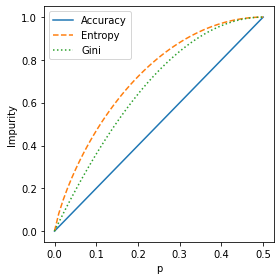

In [11]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.xlabel("p")
plt.ylabel("Impurity")

plt.tight_layout()
plt.show()

## Bagging and the Random Forest

The ensemble approach:

1. Develop a predictive model and record the predictions for a given data set.
2. Repeat for multiple models on the same data.
3. For each record to be predicted, take an average (or a weighted average, or a majority vote) of the predictions.

Going beyond the simple ensemble algorithm, there are two main variants of ensemble models: *bagging* and *boosting*. In the case of ensemble tree models, these are referred to as *random forest* models and *boosted tree* models.

### Bagging

Bagging is like the basic algorithm for ensembles, except that, instead of fitting the various models to the same data, each new model is fitted to a bootstrap resample (i.e., with replacement).

### Random Forest

The random forest is based on applying bagging to decision trees, with one important extension: in addition to sampling the records, the algorithm also samples the variables.

In [12]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

In [13]:
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


The out-of-bag (OOB) estimate of error is the error rate for the trained models, applied to the data left out of the training set for that tree. Using the output from the model, the OOB error can be plotted versus the number of trees in the random forest

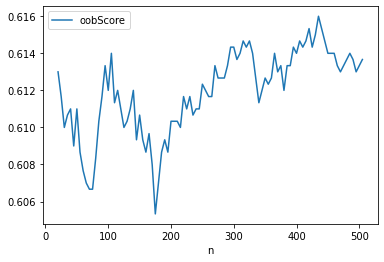

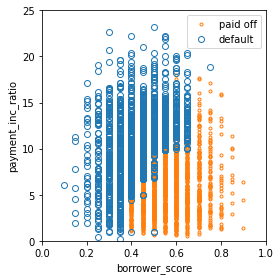

In [14]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### Variable Importance

In [15]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
 'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero',
 'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_',
 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [16]:
# gini decrease by feature
importances = rf_all.feature_importances_
importances

array([0.08005442, 0.09352543, 0.09954112, 0.10558938, 0.09391723,
       0.09773351, 0.01109408, 0.00869155, 0.06717899, 0.09668908,
       0.05262261, 0.08781408, 0.02081837, 0.00742196, 0.00743521,
       0.00357891, 0.00132007, 0.00250554, 0.00163553, 0.00139908,
       0.00434065, 0.0033695 , 0.00108048, 0.00173903, 0.00750802,
       0.00391069, 0.00351972, 0.00163962, 0.00486949, 0.00316499,
       0.00753062, 0.01335457, 0.00340649])

In [17]:
# accuracy decrease by feature
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)

# cross-validate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)

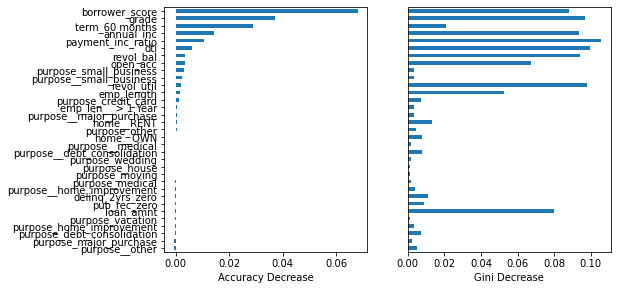

In [18]:
df = pd.DataFrame({
 'feature': X.columns,
 'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
 'Gini decrease': rf_all.feature_importances_,
})
df = df.sort_values('Accuracy decrease')
fig, axes = plt.subplots(ncols=2, figsize=(8, 4.5))
axes[0].set_xlabel("Accuracy Decrease")
axes[1].set_xlabel("Gini Decrease")
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease',
             legend=False, ax=axes[0])
ax.set_ylabel('')
ax = df.plot(kind='barh', x='feature', y='Gini decrease',
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

Since the accuracy decrease is a more reliable metric, why should we use the Gini impurity decrease measure? By default, randomForest computes only this Gini impurity: Gini impurity is a byproduct of the algorithm, whereas model accuracy by variable requires extra computations (randomly permuting the data and predicting this data). In cases where computational complexity is important, such as in a production setting where thousands of models are being fit, it may not be worth the extra computational effort. In addition, the Gini decrease sheds light on which variables the random forest is using to make its splitting rules (recall that this information, readily visible in a simple tree, is effectively lost in a random forest).

## Boosting

In linear regression models, the residuals are often examined to see if the fit can be improved (see “Partial Residual Plots and Nonlinearity” on page 185). Boosting takes this concept much further and fits a series of models, in which each successive model seeks to minimize the error of the previous model. Several variants of the algorithm are commonly used: Adaboost, gradient boosting, and stochastic gradient boosting. The latter, stochastic gradient boosting, is the most general and widely used. Indeed, with the right choice of parameters, the algorithm can emulate the random forest.

AdaBoost is an early version of boosting in which many models are trained, each one focusing more on the records that were missclassified. This emphasis on "hard" records is conveyed through a weighting factor in the final model:

$$
\hat{F} = \alpha_1\hat{f}_1 + \alpha_2\hat{f}_2 + ... + \alpha_M\hat{f}_M 
$$

Where $\hat{F}$ is the boosted estimate, and $\alpha_i$ is the factor that weights the estimates from each model.

On the other hand, Gradient boosting is similar to Adaboost but casts the problem as an optimization of a cost function. Instead of adjusting weights, gradient boosting fits models to a pseudo-residual, which has the effect of training more heavily on the larger residuals. In the spirit of the random forest, stochastic gradient boosting adds randomness to the algorithm by sampling observations and predictor variables at each stage.

### XGBoost

The most widely used public domain software for boosting is XGBoost, an implementation of stochastic gradient boosting originally developed by Tianqi Chen and Carlos Guestrin at the University of Washington.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off   

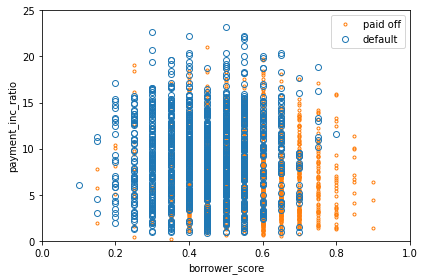

In [19]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### Regularization: Avoiding Overfitting

There are two parameters in xgboost to regularize the model: `reg_alpha` and `reg_lambda`,
which correspond to Manhattan distance (L1-regularization) and squared Euclidean distance (L2-regularization), respectively (see “Distance Metrics” on page 241). Increasing these parameters will penalize more complex models and reduce the size of the trees that are fit